**1. Table Manipulation**

We will obtain our dataset from GitHub, define the predictor (X) and response (Y) variables, and partition the data into training and testing sets.

We will begin with the model addressing the transition from naturalized (0) to invasive (1).

In [1]:
import pandas as pd
import numpy as np

d = pd.read_table("https://github.com/Thiieres/Caatinga_Invasive_Plants_ML/blob/main/nonnative_plant_caatinga_ML.txt?raw=True")

d = d.loc[d["stat"] != "inv"]
dados_y = d[['stat']]
dados_X = d.loc[:, 'LA':]
dados_y["stat"] = dados_y["stat"].replace({'exo': 0, 'nat': 1})
dados_y.head(), dados_X.head()

/tmp/ipython-input-3056399803.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dados_y["stat"] = dados_y["stat"].replace({'exo': 0, 'nat': 1})
/tmp/ipython-input-3056399803.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_y["stat"] = dados_y["stat"].replace({'exo': 0, 'nat': 1})


(   stat
 0     1
 2     0
 3     1
 4     1
 5     0,
              LA         SM         H         MPD      PDmin       MPDw  \
 0   7665.237837   7.438800  3.040096  264.121225  44.549292  12.628515   
 2  14860.630090  17.499200  1.570796  262.293329  95.377312  15.611315   
 3    878.350805   0.160000  0.429000  244.514967  65.087106  30.202390   
 4   3332.678074   0.194000  1.500000  246.086692  65.087105   8.861959   
 5  21606.235930   2.009133  0.914000  260.057211  22.462630  12.239945   
 
    Bio.1.native  Bio.10.native  Bio.11.native  Bio.12.native  ...  \
 0     23.797575      25.912865      21.193934    1060.952381  ...   
 2     21.268148      26.269678      15.522515    2165.575000  ...   
 3     11.377488      19.012068       4.019588     869.859638  ...   
 4     24.121413      25.089241      23.094658    1998.747748  ...   
 5     23.427089      25.089734      21.471330    1755.544538  ...   
 
    Bio.18.diff  Bio.19.diff  Bio.2.diff  Bio.3.diff  Bio.4.diff  Bio.5

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Partitioning the Data into Training and Testing Sets by Stratifying According to Status
X_train, X_test, y_train, y_test = train_test_split(dados_X, dados_y, test_size=0.3, random_state=42, stratify=dados_y)
y_train.value_counts(),y_test.value_counts()

# Apply SMOTE to the Training Data to Balance the Classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train.shape, y_train.shape
y_train.value_counts(), y_test.value_counts()

(stat
 0       53
 1       53
 Name: count, dtype: int64,
 stat
 1       23
 0       12
 Name: count, dtype: int64)

# 2. RandomForest

In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Building the Machine Learning Model
rf_model = RandomForestClassifier(random_state=42)
scores_rf = cross_val_score(rf_model, X_train, y_train.values.ravel(), cv=5, scoring='recall')
print(scores_rf)

[0.72727273 0.81818182 0.72727273 0.8        0.7       ]


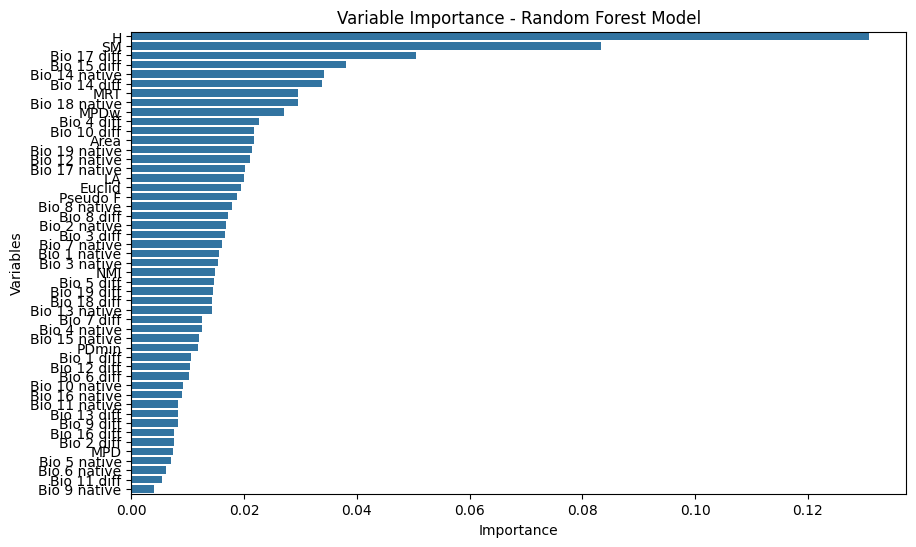

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

rf_model.fit(X_train, y_train.values.ravel())

# Extracting Variable Importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting Variable Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Variable Importance - Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.show()

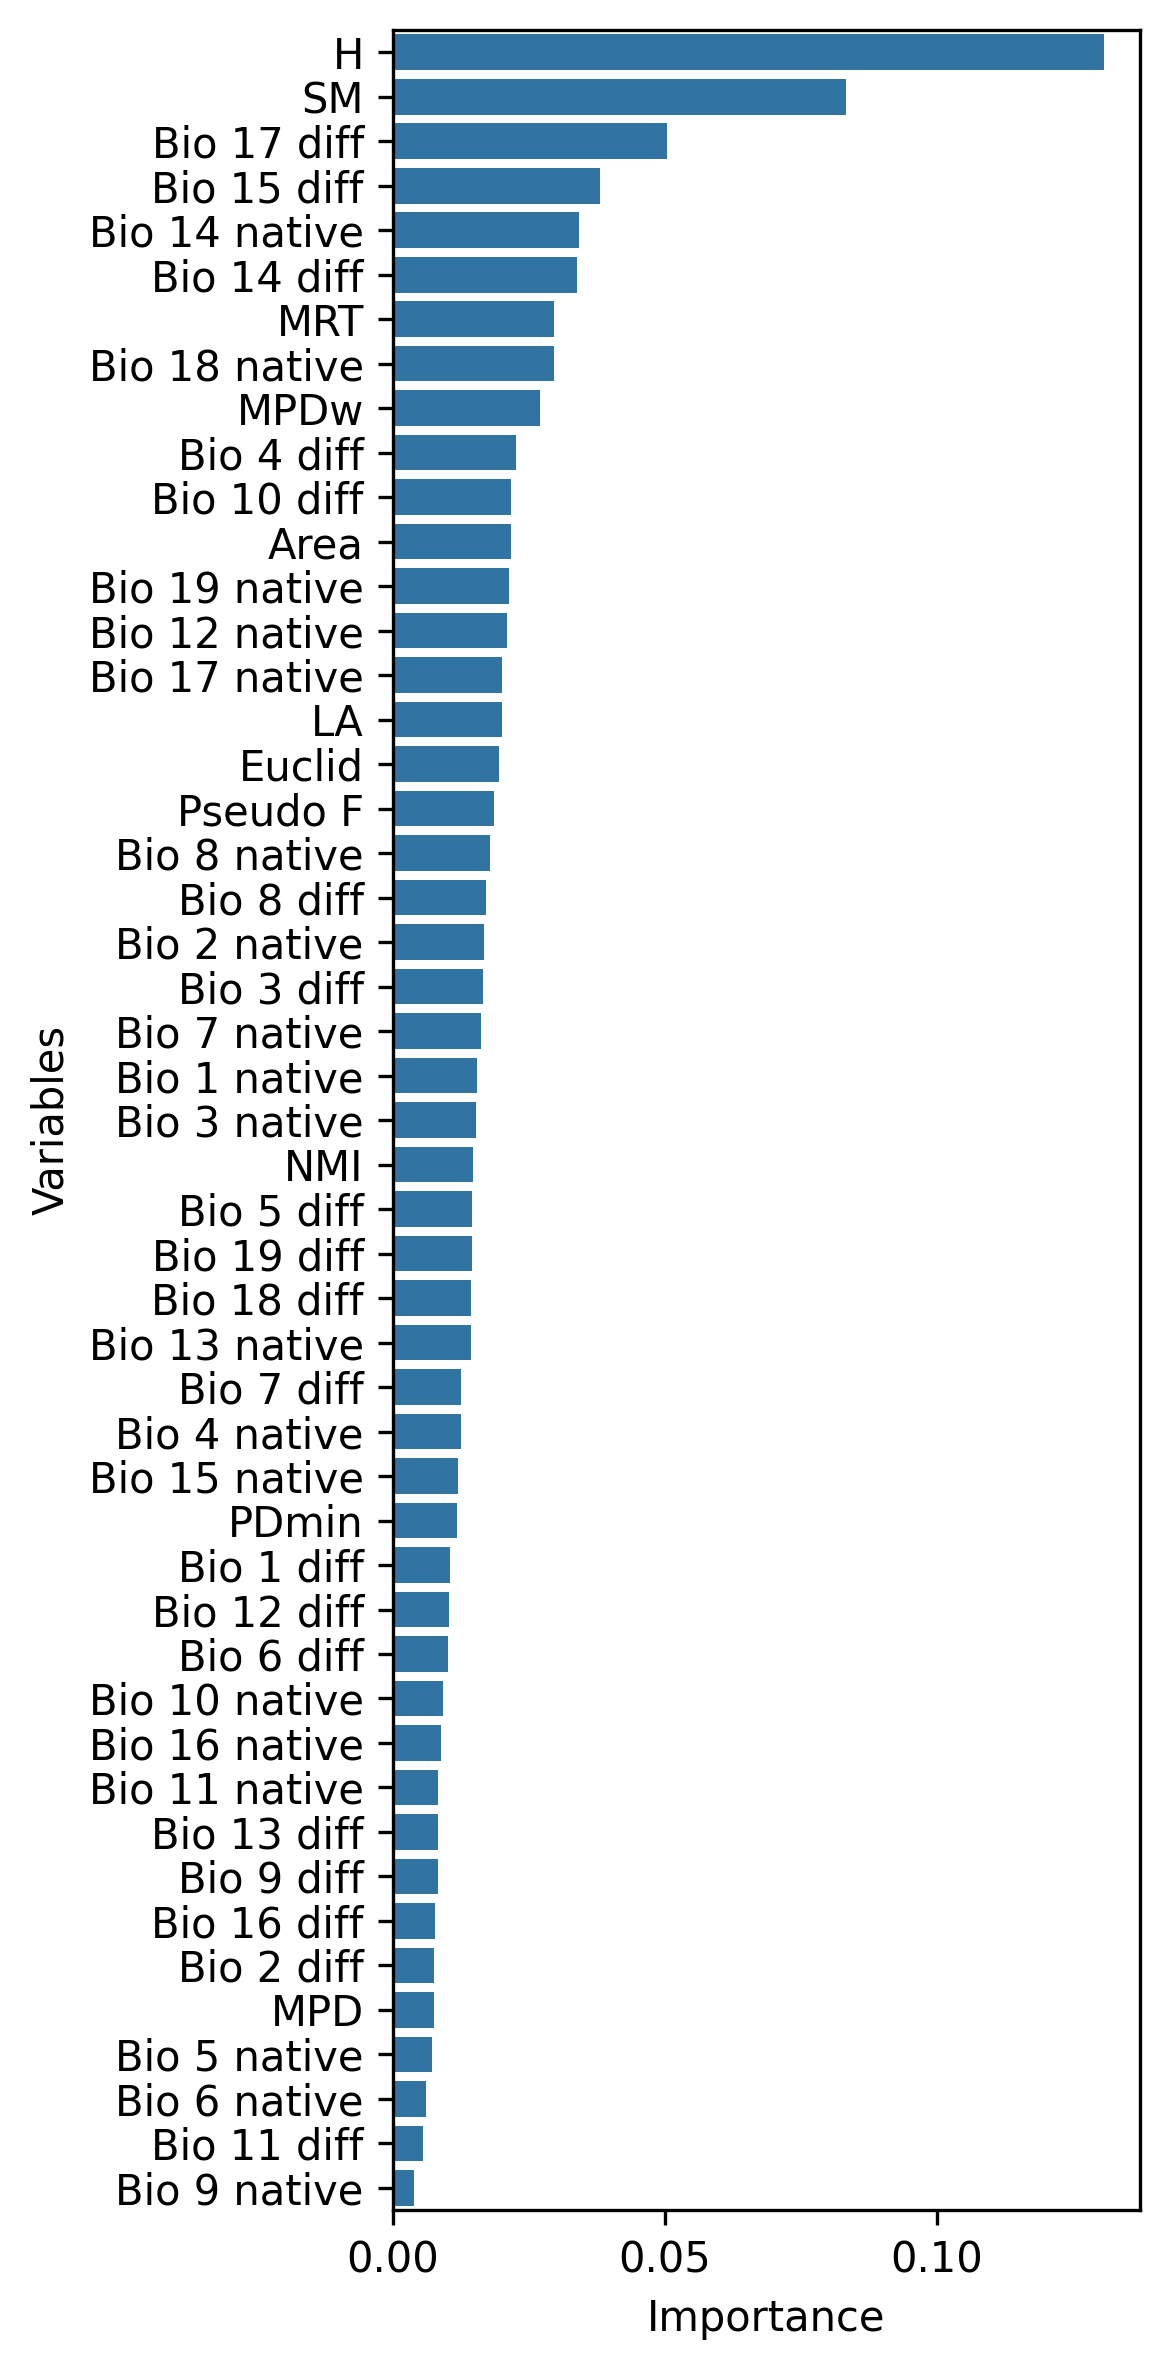

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Plotting Variable Importance
plt.figure(figsize=(4, 8), dpi=300)  # Set DPI for higher quality
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.savefig('importance_naturalization.pdf') # Save the plot as a PDF file
plt.show()

files.download('importance_naturalization.pdf')

To select the variables, we will build models and evaluate them using different subsets of variables based on their ranked importance.

We will then choose the best subset of variables, along with a few marginal subsets, for fine-tuning.

In [ ]:
# I intend to evaluate the model’s mean recall, F1 score, and accuracy using the top 1, 2, 3, 5, 10, 15, and 20 variables.
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def evaluate_model_with_top_features(model, X_train, y_train, X_test, y_test, top_n_features):
  """
  Train and evaluate a model using the top 'n' variables.
  Returns the mean recall, F1 score, and accuracy.
  """
  model.fit(X_train, y_train.values.ravel())
  y_pred = model.predict(X_test)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  return recall, f1, accuracy, auc

# List of Numbers of Variables to Test
top_n_features_list = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35]

# Dictionaries to Store the Results
results = {}

# Loop to Test Each Number of Variables
for top_n in top_n_features_list:
  # Selecting the Top n Most Important Variables
  top_features = importance_df['Feature'].head(top_n).tolist()
  X_train_subset = X_train[top_features]
  X_test_subset = X_test[top_features]

  # Training and Evaluating the Model Using the Selected Variables
  recall, f1, accuracy, auc = evaluate_model_with_top_features(rf_model, X_train_subset, y_train, X_test_subset, y_test, top_n)
  results[top_n] = {'recall': recall, 'f1': f1, 'accuracy': accuracy, "AUC":auc}

# Printing the Results
for top_n, metrics in results.items():
  print(f"With the {top_n} best variables:")
  print(f"  Recall: {metrics['recall']:.4f}")
  print(f"  F1: {metrics['f1']:.4f}")
  print(f"  Accuracy: {metrics['accuracy']:.4f}")
  print(f"  AUC: {metrics['AUC']:.4f}")

With the 1 best variables:
  Recall: 0.6957
  F1: 0.7111
  Accuracy: 0.6286
  AUC: 0.5978
With the 2 best variables:
  Recall: 0.6087
  F1: 0.6512
  Accuracy: 0.5714
  AUC: 0.5543
With the 3 best variables:
  Recall: 0.6957
  F1: 0.7273
  Accuracy: 0.6571
  AUC: 0.6395
With the 5 best variables:
  Recall: 0.6087
  F1: 0.6667
  Accuracy: 0.6000
  AUC: 0.5960
With the 10 best variables:
  Recall: 0.7391
  F1: 0.7727
  Accuracy: 0.7143
  AUC: 0.7029
With the 15 best variables:
  Recall: 0.7391
  F1: 0.7391
  Accuracy: 0.6571
  AUC: 0.6196
With the 20 best variables:
  Recall: 0.7391
  F1: 0.7556
  Accuracy: 0.6857
  AUC: 0.6612
With the 25 best variables:
  Recall: 0.8261
  F1: 0.7917
  Accuracy: 0.7143
  AUC: 0.6630
With the 30 best variables:
  Recall: 0.7391
  F1: 0.7234
  Accuracy: 0.6286
  AUC: 0.5779
With the 35 best variables:
  Recall: 0.6957
  F1: 0.7111
  Accuracy: 0.6286
  AUC: 0.5978


In [ ]:
# Sort These Sets by AUC and Recall Values to Identify the Best Variable Combinations

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df['features'] = results_df.index.map(lambda x: importance_df['Feature'].head(x).tolist())
results_df = results_df.sort_values(by=['AUC', 'recall'], ascending=False)
results_df.head(5)

,recall,f1,accuracy,AUC,features
10,0.739130,0.772727,0.714286,0.702899,"[H, SM, Bio 17 diff, Bio 15 diff, Bio 14 nativ..."
25,0.826087,0.791667,0.714286,0.663043,"[H, SM, Bio 17 diff, Bio 15 diff, Bio 14 nativ..."
20,0.739130,0.755556,0.685714,0.661232,"[H, SM, Bio 17 diff, Bio 15 diff, Bio 14 nativ..."
3,0.695652,0.727273,0.657143,0.639493,"[H, SM, Bio 17 diff]"
15,0.739130,0.739130,0.657143,0.619565,"[H, SM, Bio 17 diff, Bio 15 diff, Bio 14 nativ..."


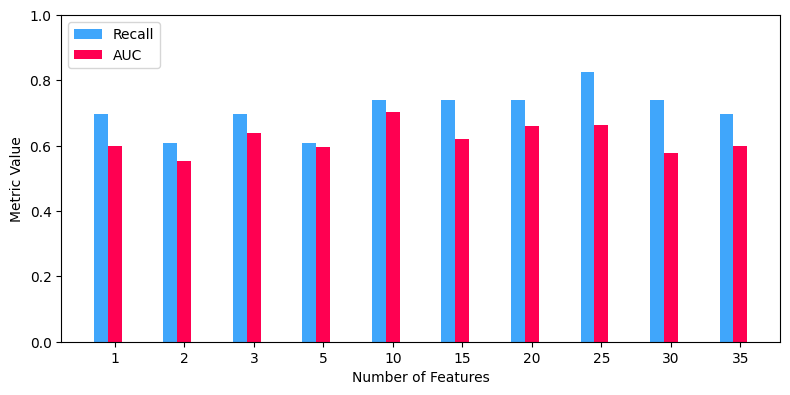

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# I want this in a grouped bar plot with different colors for each metric

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Reset the index to make 'top_n' a column
results_df = results_df.reset_index()

# Rename the 'index' column to 'Number of Features
results_df = results_df.rename(columns={'index': 'Number of Features'})

# Create a grouped bar plot
plt.figure(figsize=(8, 4))
bar_width = 0.2

# Define the x-axis positions for each group
x_positions = np.arange(len(results_df['Number of Features']))

# Plot each metric with a different color and label
plt.bar(x_positions - bar_width, results_df['recall'], width=bar_width, label='Recall', color='#40a6fb')
plt.bar(x_positions, results_df['AUC'], width=bar_width, label='AUC', color='#ff0051')

# Customize the plot (axis labels, ticks, legend, layout, limits)
plt.xlabel('Number of Features')
plt.ylabel('Metric Value')
plt.xticks(x_positions, results_df['Number of Features'])
plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim(0, 1)
plt.savefig('subsets_naturalization.pdf') # Save the plot as a PDF file
plt.show()

files.download('subsets_naturalization.pdf')

In [ ]:
# Selecting the Top 5, 10, and 20 Most Important Variables
top_25_features = importance_df['Feature'].head(25).tolist()
top_10_features = importance_df['Feature'].head(10).tolist()
top_20_features = importance_df['Feature'].head(20).tolist()

# Filtering the Training and Testing Data Using the Selected Variables

X_train_25 = X_train[top_25_features]
X_test_25 = X_test[top_25_features]
X_train_10 = X_train[top_10_features]
X_test_10 = X_test[top_10_features]
X_train_20 = X_train[top_20_features]
X_test_20 = X_test[top_20_features]


print("Selected Variables:", top_25_features)
print("Selected Variables:", top_10_features)
print("Selected Variables:", top_20_features)

Selected Variables: ['H', 'SM', 'Bio 17 diff', 'Bio 15 diff', 'Bio 14 native', 'Bio 14 diff', 'MRT', 'Bio 18 native', 'MPDw', 'Bio 4 diff', 'Bio 10 diff', 'Area', 'Bio 19 native', 'Bio 12 native', 'Bio 17 native', 'LA', 'Euclid', 'Pseudo F', 'Bio 8 native', 'Bio 8 diff', 'Bio 2 native', 'Bio 3 diff', 'Bio 7 native', 'Bio 1 native', 'Bio 3 native']
Selected Variables: ['H', 'SM', 'Bio 17 diff', 'Bio 15 diff', 'Bio 14 native', 'Bio 14 diff', 'MRT', 'Bio 18 native', 'MPDw', 'Bio 4 diff']
Selected Variables: ['H', 'SM', 'Bio 17 diff', 'Bio 15 diff', 'Bio 14 native', 'Bio 14 diff', 'MRT', 'Bio 18 native', 'MPDw', 'Bio 4 diff', 'Bio 10 diff', 'Area', 'Bio 19 native', 'Bio 12 native', 'Bio 17 native', 'LA', 'Euclid', 'Pseudo F', 'Bio 8 native', 'Bio 8 diff']


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def perform_gridsearch_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test):
  """
  Perform GridSearchCV and return evaluation metrics for the best model.
  """
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=5)
  grid_search.fit(X_train, y_train.values.ravel())

  best_model = grid_search.best_estimator_
  y_pred = best_model.predict(X_test)

  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  y_pred_proba = best_model.predict_proba(X_test)[:, 1]
  auc = roc_auc_score(y_test, y_pred_proba)

  return recall, f1, accuracy, auc, best_model, grid_search.best_params_


# Define the Model and GridSearchCV for Each Variable Subset
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [25, 50, 100, 150, 200],
    'max_depth': [None, 2, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

# Apply GridSearchCV and Evaluate the Model for Each Variable Subset
results_25 = perform_gridsearch_and_evaluate(rf_model, param_grid, X_train_25, y_train, X_test_25, y_test)
results_10 = perform_gridsearch_and_evaluate(rf_model, param_grid, X_train_10, y_train, X_test_10, y_test)
results_20 = perform_gridsearch_and_evaluate(rf_model, param_grid, X_train_20, y_train, X_test_20, y_test)


# Print the results
print("\nResults with 25 variables:")
print(f"  Recall: {results_25[0]:.4f}")
print(f"  F1: {results_25[1]:.4f}")
print(f"  Accuracy: {results_25[2]:.4f}")
print(f"  AUC: {results_25[3]:.4f}")
print(f"  Best Parameters: {results_25[5]}")

print("\nResults with 10 variables:")
print(f"  Recall: {results_10[0]:.4f}")
print(f"  F1: {results_10[1]:.4f}")
print(f"  Accuracy: {results_10[2]:.4f}")
print(f"  AUC: {results_10[3]:.4f}")
print(f"  Best Parameters: {results_10[5]}")

print("\nResults with 20 variables:")
print(f"  Recall: {results_20[0]:.4f}")
print(f"  F1: {results_20[1]:.4f}")
print(f"  Accuracy: {results_20[2]:.4f}")
print(f"  AUC: {results_20[3]:.4f}")
print(f"  Best Parameters: {results_20[5]}")


Results with 25 variables:
  Recall: 0.6957
  F1: 0.7111
  Accuracy: 0.6286
  AUC: 0.6830
  Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Results with 10 variables:
  Recall: 0.7826
  F1: 0.7660
  Accuracy: 0.6857
  AUC: 0.6377
  Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 25}

Results with 20 variables:
  Recall: 0.6957
  F1: 0.7111
  Accuracy: 0.6286
  AUC: 0.6848
  Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 25}


Five variables are the most appropriate, improving all metrics. We will proceed with 'H', 'SM', 'bio_17_p', 'bio_15_p', 'bio_14_p'.

3. Initial Model Training

In [ ]:
## Extracting the predictor variables (X) for training and testing, already filtered based on our selected variables
## ['F_pres', 'mpds_weighted', 'Area_p']

X_train = X_train[['H', 'SM', 'Bio 17 diff', 'Bio 15 diff', 'Bio 14 native', 'Bio 14 diff', 'MRT', 'Bio 18 native', 'MPDw', 'Bio 4 diff']]
X_test = X_test[['H', 'SM', 'Bio 17 diff', 'Bio 15 diff', 'Bio 14 native', 'Bio 14 diff', 'MRT', 'Bio 18 native', 'MPDw', 'Bio 4 diff']]

X_train.head(), X_test.head()

(           H         SM  Bio 17 diff  Bio 15 diff  Bio 14 native  Bio 14 diff  \
 0   3.040096     7.4388   -14.952381   -12.952376      19.809524    -5.738095   
 1  15.000000  2380.0000  -268.666667    19.832068      94.266667   -79.666667   
 2   4.570000   189.9040   -45.098039    11.848295      23.941176    -9.674510   
 3   6.082000  1443.8030   -72.505792    10.459690      33.301158   -21.158301   
 4   1.000000    13.5400   -94.022428    20.975291      34.769366   -26.291105   
 
    MRT  Bio 18 native       MPDw  Bio 4 diff  
 0  121     322.857143  12.628515  -52.482541  
 1  271     519.400000   8.405428   25.634549  
 2  208     344.392157   8.319338  -20.946566  
 3  156     560.826255  13.712457 -628.220525  
 4  257     434.286972   9.113346  -51.689775  ,
              H          SM  Bio 17 diff  Bio 15 diff  Bio 14 native  \
 61    0.265000    0.517000  -112.850741    67.636476      40.878889   
 20   15.000000   36.290845  -110.759286    19.823211      45.210000   
 

In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

# RandomForest parameters
rf_model = RandomForestClassifier(random_state=42)

param_rf = {
    'n_estimators': [25, 30, 45, 50, 100, 150, 200, 250, 300, 350],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# CatBoost
!pip install catboost
from catboost import CatBoostClassifier

# CatBoost parameters
cat_model = CatBoostClassifier(random_state=42, verbose=0)

param_cat = {
    'depth': [4, 6, 8, 10],                        # Tree depth, adjusting model complexity
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], # Learning rate, controlling how fast the model learns
    'iterations': [50, 100, 200, 500, 1000],      # Number of trees for training
    'l2_leaf_reg': [1, 3, 5, 7, 9],               # L2 regularization for leaves, helping control overfitting
    'border_count': [32, 64, 128, 255],           # Number of splits for numerical features, adjusting binning
    'bagging_temperature': [0.0, 0.2, 0.5, 1.0],  # Controls random sampling; higher values increase tree diversity
    'random_strength': [0.0, 0.2, 0.5, 1.0]       # Controls randomness in node splitting
}

# XGBoost
from xgboost import XGBClassifier

# XGBoost parameters
xgb_model = XGBClassifier(random_state=42)

param_xgb = {
    'n_estimators': [25, 30, 45, 50, 100, 150, 200, 250, 300, 350],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_child_weight': list(range(1, 16)),       # Minimum sum of instance weight needed in a child
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],            # Minimum loss reduction required for a split
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],      # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Fraction of features used per tree
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100], # L1 regularization term
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100] # L2 regularization term
}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.8 MB/s eta 0:00:00


# RandomForest finetuning




In [ ]:
from sklearn.model_selection import RandomizedSearchCV
search_rf = RandomizedSearchCV(rf_model, param_distributions=param_rf,
                                n_iter=100, cv=5,scoring='recall', random_state=42)
search_rf.fit(X_train, y_train.values.ravel())
rf_params = search_rf.best_params_
print("Best recall:", search_rf.best_score_)
print("Best Parameters:",search_rf.best_params_)

Best recall: 0.8309090909090908
Best Parameters: {'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': None}


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

## Tuned model with the best parameters
rf_model = RandomForestClassifier(
    n_estimators=25,
    min_samples_split=5,
    min_samples_leaf=3,
    max_depth=None,
    random_state=42
)

rf_model.fit(X_train, y_train.values.ravel())

scores_rf = cross_val_score(rf_model, X_train, y_train.values.ravel(), cv=5, scoring='recall')
print("Recall with the best parameters (CV):", scores_rf)

Recall with the best parameters (CV): [0.81818182 0.81818182 0.81818182 1.         0.7       ]


In [ ]:
# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model on the test set
report_rf = classification_report(y_test, y_pred_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.55      0.50      0.52        12
           1       0.75      0.78      0.77        23

    accuracy                           0.69        35
   macro avg       0.65      0.64      0.64        35
weighted avg       0.68      0.69      0.68        35



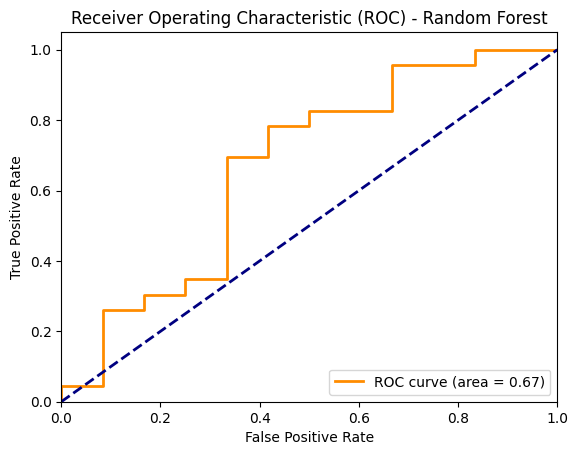

AUC for Random Forest: 0.6666666666666666


In [ ]:
# I want to create a ROC curve and compute the AUC for this prediction
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.show()

print(f"AUC for Random Forest: {roc_auc_rf}")

# CatBoost finetunning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

search_cat = RandomizedSearchCV(cat_model, param_distributions=param_cat,
                                n_iter=200, cv=5,scoring='recall', random_state=42, n_jobs = -1)
search_cat.fit(X_train, y_train.values.ravel())
cat_params = search_cat.best_params_
print("Best recall:", search_cat.best_score_)
print("Best Parameters:",search_cat.best_params_)

Best recall: 0.8672727272727274
Best Parameters: {'random_strength': 0.0, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8, 'border_count': 32, 'bagging_temperature': 0.5}


In [ ]:
## Tuned model with the best parameters
cat_model = CatBoostClassifier(
    random_strength=0,
    learning_rate=0.2,
    l2_leaf_reg=1,
    iterations=1000,
    depth=8,
    border_count=32,
    bagging_temperature=0.5,
    random_state=42,
    verbose=False
)

cat_model.fit(X_train, y_train.values.ravel())

scores_cat = cross_val_score(cat_model, X_train, y_train.values.ravel(), cv=5, scoring='recall')
print("Recall with the best parameters (CV):", scores_cat)

Recall with the best parameters (CV): [0.81818182 0.81818182 1.         0.9        0.8       ]


In [ ]:
# Making predictions on the test set
y_pred_cat = cat_model.predict(X_test)

# Evaluating the model on the test set
report_cat = classification_report(y_test, y_pred_cat)
print(report_cat)

              precision    recall  f1-score   support

           0       0.47      0.67      0.55        12
           1       0.78      0.61      0.68        23

    accuracy                           0.63        35
   macro avg       0.62      0.64      0.62        35
weighted avg       0.67      0.63      0.64        35



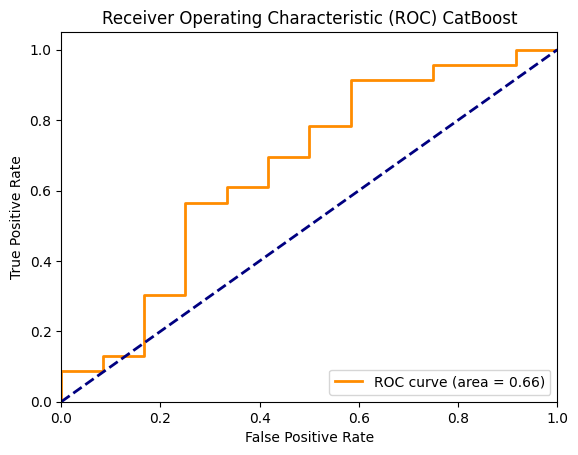

AUC for CatBoost: 0.6594202898550724


In [ ]:
# Predict probabilities for the positive class
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_test, y_pred_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

# Plot ROC curve
plt.figure()
plt.plot(fpr_cat, tpr_cat, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cat)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) CatBoost')
plt.legend(loc="lower right")
plt.show()

print(f"AUC for CatBoost: {roc_auc_cat}")

# XGBoost finetunning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
xgb_model
search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_xgb,
                                n_iter=200, cv=5,scoring='recall', random_state=42, n_jobs = -1)
search_xgb.fit(X_train, y_train.values.ravel())
xgb_params = search_xgb.best_params_
print("Best recall:", search_xgb.best_score_)
print("Best parameters:",search_xgb.best_params_)

Best recall: 1.0
Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.001, 'n_estimators': 25, 'min_child_weight': 10, 'max_depth': None, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [ ]:
# I want to visualize the results of search_xgb with all tested parameters
results_df_xgb = pd.DataFrame(search_xgb.cv_results_)

print(results_df_xgb[['params', 'mean_test_score']])

from google.colab import files

# Save the results as a CSV file and download
results_df_xgb.to_csv('results_df_xgb.csv', encoding='utf-8-sig')
files.download('results_df_xgb.csv')

                                                params  mean_test_score
0    {'subsample': 1.0, 'reg_lambda': 0.01, 'reg_al...         0.829091
1    {'subsample': 0.9, 'reg_lambda': 0.001, 'reg_a...         0.400000
2    {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha...         0.400000
3    {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha...         0.400000
4    {'subsample': 0.9, 'reg_lambda': 10, 'reg_alph...         0.890909
..                                                 ...              ...
195  {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha...         0.600000
196  {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_al...         0.849091
197  {'subsample': 0.6, 'reg_lambda': 0.001, 'reg_a...         0.200000
198  {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha...         0.600000
199  {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alp...         0.400000

[200 rows x 2 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 300,
#  'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.01,
#  'gamma': 0.4, 'colsample_bytree': 0.9}

# Original second-best set of parameters
## Tuned model with the best parameters
xgb_model = XGBClassifier(
    subsample=0.9,
    reg_lambda=10,
    reg_alpha=0,
    n_estimators=300,
    min_child_weight=10,
    max_depth=6,
    learning_rate=0.01,
    gamma=0.4,
    colsample_bytree=0.9,
    random_state=42
)

xgb_model.fit(X_train, y_train.values.ravel())

from sklearn.model_selection import cross_val_score
scores_xgb = cross_val_score(xgb_model, X_train, y_train.values.ravel(), cv=5, scoring='recall')
print("Recall with the best parameters (CV):", scores_xgb)

Recall with the best parameters (CV): [0.72727273 0.72727273 1.         1.         1.        ]


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# Making predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluating the model on the test set
report_xgb = classification_report(y_test, y_pred_xgb)
print(report_xgb)

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.74      0.74      0.74        23

    accuracy                           0.66        35
   macro avg       0.62      0.62      0.62        35
weighted avg       0.66      0.66      0.66        35



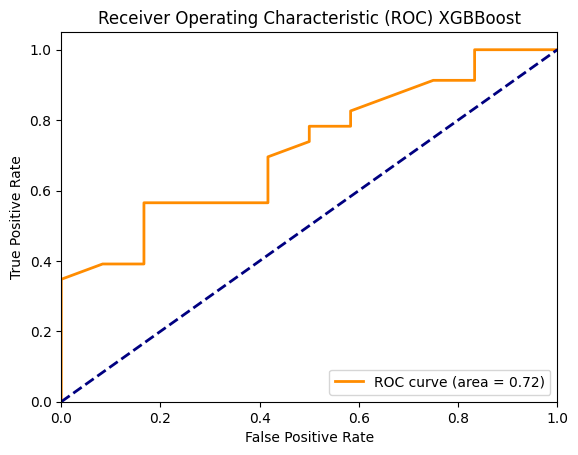

AUC for XGBoost: 0.717391304347826


In [ ]:
import matplotlib.pyplot as plt
# Predict probabilities for the positive class
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curve
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) XGBBoost')
plt.legend(loc="lower right")
plt.show()

print(f"AUC for XGBoost: {roc_auc_xgb}")

In [ ]:
print(f"AUC for RandomForest: {roc_auc_rf}")
print(f"AUC for CatBoost: {roc_auc_cat}")
print(f"AUC for XGBoost: {roc_auc_xgb}")

AUC for RandomForest: 0.6666666666666666
AUC for CatBoost: 0.6594202898550724
AUC for XGBoost: 0.717391304347826


In [ ]:
print("XGB",report_xgb)
print("RF",report_rf)
print("CAT",report_cat)

XGB               precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.74      0.74      0.74        23

    accuracy                           0.66        35
   macro avg       0.62      0.62      0.62        35
weighted avg       0.66      0.66      0.66        35

RF               precision    recall  f1-score   support

           0       0.55      0.50      0.52        12
           1       0.75      0.78      0.77        23

    accuracy                           0.69        35
   macro avg       0.65      0.64      0.64        35
weighted avg       0.68      0.69      0.68        35

CAT               precision    recall  f1-score   support

           0       0.47      0.67      0.55        12
           1       0.78      0.61      0.68        23

    accuracy                           0.63        35
   macro avg       0.62      0.64      0.62        35
weighted avg       0.67      0.63      0.64        35



In [ ]:
# I want to calculate the TSS (True Skill Statistic) for each algorithm

from sklearn.metrics import roc_auc_score, roc_curve, auc

# Assuming y_test and y_pred_proba are available for each model (rf, cat, xgb)

def calculate_tss(y_true, y_pred_proba):
    """Calculates the True Skill Statistic (TSS)."""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    tss = roc_auc * 2 - 1
    return tss

# Calculate TSS for each model
tss_rf = calculate_tss(y_test, y_pred_proba_rf)
tss_cat = calculate_tss(y_test, y_pred_proba_cat)
tss_xgb = calculate_tss(y_test, y_pred_proba_xgb)

print(f"TSS for Random Forest: {tss_rf}")
print(f"TSS for CatBoost: {tss_cat}")
print(f"TSS for XGBoost: {tss_xgb}")

TSS for Random Forest: 0.33333333333333326
TSS for CatBoost: 0.3188405797101448
TSS for XGBoost: 0.4347826086956521
